Генерация фамилий по категориям

In [0]:
%matplotlib inline

In [0]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

import torch
import torch.nn as nn
import torch.optim as optim

import random

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def get_files(path): 
  return glob.glob(path)

In [0]:
LETTERS = string.ascii_letters + " .,;'-"
LETTERS_NUM = len(LETTERS) + 1

In [0]:
def uni2asc(name):
    return ''.join(c for c in unicodedata.normalize('NFD', name) if unicodedata.category(c) != 'Mn' and c in LETTERS)

In [0]:
def file2lines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [uni2asc(line) for line in lines]

In [0]:
DICTIONARY = {}
CATEGORIES = []

In [0]:
MAX_LENGTH = 20

In [0]:
for filename in get_files('/content/gdrive/My Drive/Data/Names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    CATEGORIES.append(category)
    lines = file2lines(filename)
    DICTIONARY[category] = lines

In [0]:
CATEGORIES_NUM = len(CATEGORIES)

In [12]:
print(CATEGORIES_NUM, CATEGORIES)

18 ['Japanese', 'Italian', 'Greek', 'English', 'Scottish', 'Polish', 'Spanish', 'Russian', 'French', 'Korean', 'Chinese', 'Portuguese', 'German', 'Arabic', 'Irish', 'Czech', 'Vietnamese', 'Dutch']


In [0]:
class Generator(nn.Module):
    def __init__(self, inp_dim, emb_dim, hid_dim, out_dim):
        super().__init__()
        self.inp_dim = inp_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.inp2emb = nn.Linear(CATEGORIES_NUM + inp_dim, emb_dim)
        self.emb2hid = nn.LSTMCell(emb_dim, hid_dim)
        self.hid2out = nn.Linear(hid_dim, out_dim)
        self.drop = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim = 1)

    def forward(self, category, inp, h, c):
        emb = self.inp2emb(torch.cat((category, inp), 1))
        (h, c) = self.emb2hid(emb, (h, c))
        out = self.softmax(self.drop(self.hid2out(h)))
        return out, h, c

In [0]:
def rand_elem(elems):
  return elems[random.randint(0, len(elems) - 1)]

In [0]:
def rand_pair():
  category = rand_elem(CATEGORIES)
  name = rand_elem(DICTIONARY[category])
  return category, name

In [0]:
def cat2ten(categories):
  tensor = torch.zeros(len(categories), CATEGORIES_NUM).type(torch.FloatTensor).to(device)
  for i in range(len(categories)):
    tensor[i][CATEGORIES.index(categories[i])] = 1
  return tensor

In [0]:
def inp2ten(names):
  tensor = torch.zeros(MAX_LENGTH, len(names), LETTERS_NUM).type(torch.FloatTensor).to(device)
  for i in range(len(names)):
    for j in range(len(names[i])):
      letter = names[i][j]
      tensor[j][i][LETTERS.index(letter)] = 1
    for j in range(len(names[i]), MAX_LENGTH):
      tensor[j][i][LETTERS.index(' ')] = 1
  return tensor

In [0]:
def trg2ten(names):
  tensor = torch.zeros(MAX_LENGTH, len(names)).type(torch.LongTensor).to(device)
  for i in range(len(names)):
    for j in range(0, len(names[i]) - 1):
      tensor[j][i] = LETTERS.index(names[i][j + 1])
    for j in range(len(names[i]) - 1, MAX_LENGTH):
      tensor[j][i] = LETTERS.index(' ')
    tensor[MAX_LENGTH - 1][i] = LETTERS_NUM - 1
  return tensor

In [0]:
def rand_batch(batch_size):
  categories = []
  names = []
  for i in range(batch_size):
    category, name = rand_pair()
    categories.append(category)
    names.append(name)
  cat_ten = cat2ten(categories)
  inp_ten = inp2ten(names)
  trg_ten = trg2ten(names)
  return cat_ten, inp_ten, trg_ten

In [0]:
cat_ten, inp_ten, trg_ten = rand_batch(32)
h, c = torch.zeros(32, 128), torch.zeros(32, 128)

loss = 0

for i in range(inp_ten.size(0)):
  out, h, c = generator(cat_ten, inp_ten[i], h, c)
  l = crit(out, trg_ten[i])
  loss += l

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

In [0]:
inp_dim = LETTERS_NUM
emb_dim = 128
hid_dim = 128
out_dim = LETTERS_NUM

In [21]:
generator = Generator(inp_dim, emb_dim, hid_dim, out_dim)
generator

Generator(
  (inp2emb): Linear(in_features=77, out_features=128, bias=True)
  (emb2hid): LSTMCell(128, 128)
  (hid2out): Linear(in_features=128, out_features=59, bias=True)
  (drop): Dropout(p=0.1, inplace=False)
  (softmax): LogSoftmax()
)

In [0]:
def init_state():
  return torch.zeros(batch_size, hid_dim).to(device), torch.zeros(batch_size, hid_dim).to(device)

In [0]:
def train(model, cat_ten, inp_ten, trg_ten):
    h, c = init_state()

    loss = 0

    for i in range(inp_ten.size(0)):
        out, h, c = model(cat_ten, inp_ten[i], h, c)
        l = crit(out, trg_ten[i])
        loss += l

    opt.zero_grad()
    loss.backward()
    opt.step()

    return out, loss.item() / inp_ten.size(0)

In [0]:
import time
import math

def delta_time(start):
    now = time.time()
    s = now - start
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
crit = nn.NLLLoss()
opt = optim.Adam(generator.parameters())
lr = 1e-5

In [0]:
batch_size = 32
epochs_num = 3000
losses = []

In [0]:
best = float('inf')

In [0]:
best

0.6528499603271485

In [0]:
start = time.time()
for epoch in range(1, epochs_num + 1):
    out, loss = train(generator, *rand_batch(batch_size))
  
    if epoch % 10 == 0:
        print('%s (%d %d%%) %.4f' % (delta_time(start), epoch, epoch / epochs_num * 100, loss))
        losses.append(loss)

    if loss < best:
      best = loss
      torch.save(generator.state_dict(), '/content/gdrive/My Drive/Models/categories.pt')

0m 0s (10 0%) 3.3217
0m 0s (20 0%) 1.6193
0m 1s (30 1%) 1.8390
0m 1s (40 1%) 1.7101
0m 2s (50 1%) 1.4862
0m 2s (60 2%) 1.5272
0m 2s (70 2%) 1.5582
0m 3s (80 2%) 1.3691
0m 3s (90 3%) 1.4377
0m 4s (100 3%) 1.3893
0m 4s (110 3%) 1.3048
0m 4s (120 4%) 1.2869
0m 5s (130 4%) 1.3281
0m 5s (140 4%) 1.3930
0m 5s (150 5%) 1.2269
0m 6s (160 5%) 1.2223
0m 6s (170 5%) 1.2830
0m 7s (180 6%) 1.2773
0m 7s (190 6%) 1.1351
0m 7s (200 6%) 1.1821
0m 8s (210 7%) 1.2431
0m 8s (220 7%) 1.1451
0m 8s (230 7%) 1.2642
0m 9s (240 8%) 1.0670
0m 9s (250 8%) 1.0559
0m 10s (260 8%) 1.2305
0m 10s (270 9%) 1.0930
0m 10s (280 9%) 1.0439
0m 11s (290 9%) 1.1034
0m 11s (300 10%) 1.1158
0m 12s (310 10%) 1.0871
0m 12s (320 10%) 1.0753
0m 12s (330 11%) 1.0745
0m 13s (340 11%) 1.0080
0m 13s (350 11%) 1.1418
0m 13s (360 12%) 1.1182
0m 14s (370 12%) 1.2804
0m 14s (380 12%) 1.0964
0m 15s (390 13%) 1.0456
0m 15s (400 13%) 0.9046
0m 15s (410 13%) 0.9749
0m 16s (420 14%) 1.0516
0m 16s (430 14%) 0.9974
0m 16s (440 14%) 1.0778
0m 17s 

In [0]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

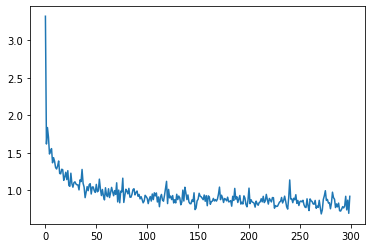

In [0]:
plt.figure()
plt.plot(losses)

In [0]:
import numpy as np

In [0]:
def sample(model, category, start):
  with torch.no_grad():
    cat_ten = cat2ten([category])
    inp_ten = inp2ten([start])
    h, c = torch.zeros(1, hid_dim), torch.zeros(1, hid_dim)
    
    out_name = start
    for i in range(MAX_LENGTH):
      out, h, c = model(cat_ten, inp_ten[0], h, c)
      top_ind = out.argmax()
      top_ind = top_ind.item()
      if top_ind != LETTERS_NUM - 1:
        letter = LETTERS[top_ind]
        out_name += letter
      else:
        break
      inp_ten = inp2ten(letter)
  return out_name

In [0]:
def samples(model, category, start_list):
  for start in start_list:
    print(sample(model, category, start))

In [79]:
samples(generator, 'Russian', 'RUSSIAN')

Rohalov             
Unton    ,          
Shalov          ,   
Shalov              
Ishanov             
Antovan    ,  ;  -  
Nakhan              


In [24]:
generator.load_state_dict(torch.load('/content/gdrive/My Drive/Models/categories.pt'))

<All keys matched successfully>

In [32]:
samples(generator, 'Russian', 'ABCDEF')

Antovan    .    ,   
Barikov   ,         
Chalov              
Dunininski          
Enikhov             
Fantov    ;         


In [52]:
samples(generator, 'Russian', 'AAAAAAAAAAAAAAAA')

Antovan          .  
Antovan             
Antovan        .  - 
Antovan           , 
Antovak             
Antovan    
Antovanov       ;   
Antovan             
Antovan             
Antovak         ,   
Antolov             
Antovan   ,        
Antovak    ,        
Abanovav            
Antovanov           
Antan               


In [84]:
samples(generator, 'German', 'ABCDEF')

Abert  '   ;        
Barter              
Chenter        '    
Denter       ;      
Enter               
Ferner              


In [87]:
samples(generator, 'English', 'ABCDEF')

Anten             ;
Banter              
Chert               
Donner              
Enterson            
Ferter              


In [39]:
samples(generator, 'French', 'ABCDEF')

Alleid             ,
Barter              
Cherrier            
Denter              
Enten               
Feller              


In [40]:
samples(generator, 'Italian', 'ABCDEF')

Albuici             
Barto               
Canto        
Dentini     -      
Esti       '        
Farro               


In [41]:
samples(generator, 'Japanese', 'ABCDEF')

Amaki               
Baka , ;-        
Cakushi           
Dunaka              
Eshishis     ;      
Fanaki      - -   


In [42]:
samples(generator, 'Polish', 'ABCDEF')

Allan               
Banak         ;     
Callak              
Dunawak              
Essako               
Falla               


In [88]:
samples(generator, 'Greek', 'ABCDEF')

Alassis             
Bostos              
Cartos             
Doulis   .          
Estas              
Fartos  
